In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
import os
import glob
import random
from shutil import copyfile

In [104]:
names_file = 'training.csv'
ts = 0.29
wh = 32

In [4]:
df = pd.read_csv(names_file)
# df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Unnamed: 0,id,name,type,w,h,dataset,diagnosis,diagnosis_confirm_type,age,sex
0,0,5aaf12491165976913627e89,ISIC_0024306,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,45,male
1,1,5aaf12491165976913627e95,ISIC_0024307,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,50,male
2,2,5aaf12491165976913627ea0,ISIC_0024308,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,55,female
3,3,5aaf12491165976913627eab,ISIC_0024309,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,40,male
4,4,5aaf12491165976913627eb6,ISIC_0024310,dermoscopic,600,450,HAM10000,melanoma,histopathology,60,male


In [5]:
X = df['name']
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [19]:
def plot_hist(data, name=""):
    plt.figure(figsize=(16,5))
    plt.xticks(rotation=45)
    plt.title(name)
    sns.countplot(data);   

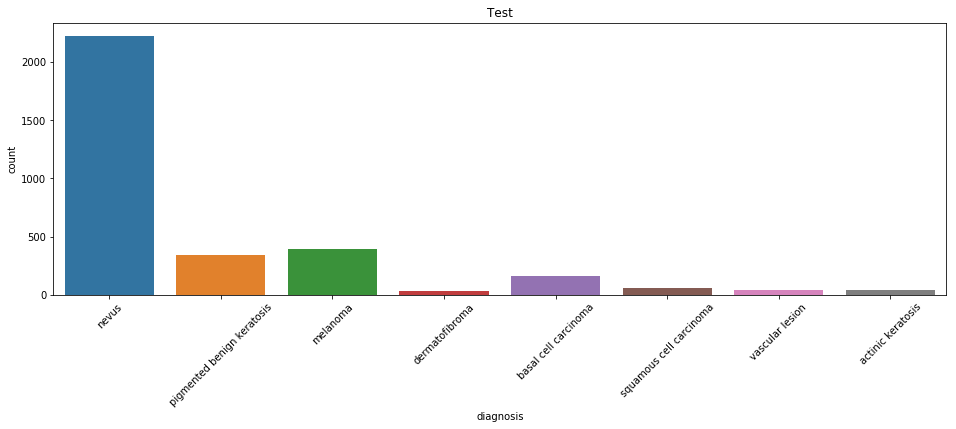

In [20]:
plot_hist(y_test, "Test")

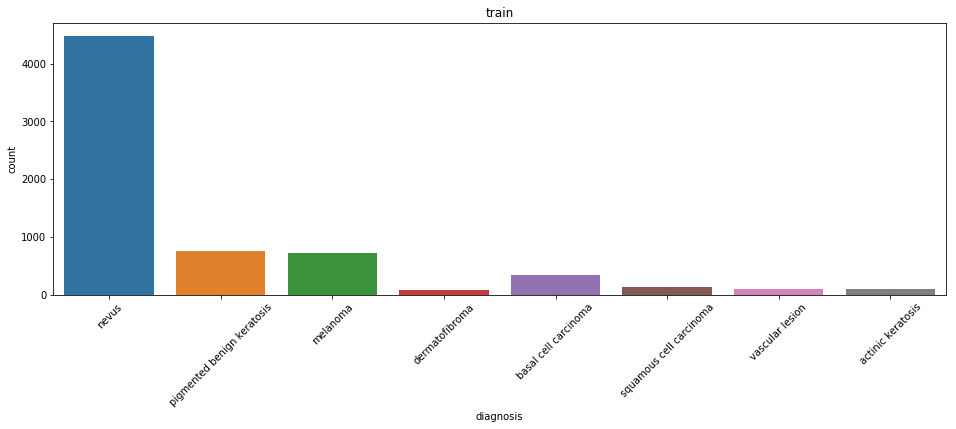

In [21]:
plot_hist(y_train, "train")

In [22]:
folder_names = list(y_train.unique())
folder_names

['nevus',
 'pigmented benign keratosis',
 'melanoma',
 'dermatofibroma',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'vascular lesion',
 'actinic keratosis']

In [24]:
for fn in folder_names:
    train_folder = 'train/' + fn
    valid_folder = 'test/' + fn
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(valid_folder):
        os.makedirs(valid_folder)

In [11]:
X_train_list = list(X_train)
y_train_list = list(y_train)
for i in range(len(X_train_list)):
    old_path = 'img/' + X_train_list[i] + ".jpg"
    new_path = 'train' + '/' + y_train_list[i] + '/' + X_train_list[i] + ".jpg"
    os.replace(old_path, new_path)

In [12]:
X_test_list = list(X_test)
y_test_list = list(y_test)
for i in range(len(X_test_list)):
    old_path = 'img/' + X_test_list[i] + ".jpg"
    new_path = 'test/' + y_test_list[i] + '/' + X_test_list[i] + ".jpg"
    os.replace(old_path, new_path)

## Обрез до 32х32 и копирование в новую папку

In [3]:
def resize_img(name, new_path, size):
    img = Image.open(name)
    img = img.resize((size,size))
    img.save(new_path)

In [26]:
for fn in folder_names:
    train_folder = f'train{wh}x{wh}/' + fn
    test_folder = f'test{wh}x{wh}/' + fn
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

In [27]:
train_size = 0
valid_size = 0
for fn in folder_names:
    train_size+=len(os.listdir('train/' + fn))
    valid_size+=len(os.listdir('test/' + fn))
train_size, valid_size

(6710, 3305)

In [8]:
for fn in folder_names:
    folder = 'train/' + fn
    for img in os.listdir(folder):
        name = folder + '/' + img
        new_path = 'train{}/'.format(wh) + fn + '/'+ img.split('.')[0] + '_{}x{}.jpg'.format(wh,wh)
        resize_img(name, new_path, wh)
    print('Done {} / {}. Class - {}'.format(folder_names.index(fn) + 1, len(folder_names), fn))

Done 1 / 8. Class - actinic keratosis
Done 2 / 8. Class - basal cell carcinoma
Done 3 / 8. Class - dermatofibroma
Done 4 / 8. Class - melanoma
Done 5 / 8. Class - nevus
Done 6 / 8. Class - pigmented benign keratosis
Done 7 / 8. Class - squamous cell carcinoma
Done 8 / 8. Class - vascular lesion


In [9]:
for fn in folder_names:
    folder = 'valid/' + fn
    for img in os.listdir(folder):
        name = folder + '/' + img
        new_path = 'valid{}/'.format(wh) + fn + '/'+ img.split('.')[0] + '_{}x{}.jpg'.format(wh,wh)
        resize_img(name, new_path, wh)
    print('Done {} / {}. Class - {}'.format(folder_names.index(fn) + 1, len(folder_names), fn))

Done 1 / 8. Class - actinic keratosis
Done 2 / 8. Class - basal cell carcinoma
Done 3 / 8. Class - dermatofibroma
Done 4 / 8. Class - melanoma
Done 5 / 8. Class - nevus
Done 6 / 8. Class - pigmented benign keratosis
Done 7 / 8. Class - squamous cell carcinoma
Done 8 / 8. Class - vascular lesion


## Разбиение выборки на равные части

In [131]:
def get_segment_stat(test_folder_name, train_folder_name, folder_names_list):
    test_fn = test_folder_name
    train_fn = train_folder_name
    
    stat_dict = {'class_name' : folder_names_list, train_fn : [], test_fn : [] }
    
    for st in [train_fn, test_fn]:
        for name in os.listdir(st):
            stat_dict[st].append(len(glob.glob(f"{st}\\{name}\\*.jpg")))
            
    stat_df = pd.DataFrame(stat_dict)
    stat_df['all'] = stat_df[train_fn] + stat_df[test_fn]
    return stat_df

In [133]:
get_segment_stat("test32x32", "train32x32", folder_names)

,class_name,train32x32,test32x32,all
0,nevus,93,37,130
1,pigmented benign keratosis,349,165,514
2,melanoma,82,33,115
3,dermatofibroma,717,396,1113
4,basal cell carcinoma,4479,2226,6705
5,squamous cell carcinoma,756,343,1099
6,vascular lesion,137,60,197
7,actinic keratosis,97,45,142


In [116]:
total_lim = stat_df['all'].min()
test_lim = int(total_lim * ts)
train_lim = total_lim - test_lim
print("total = train + test")
print(total_lim, " = ", train_lim, " + ", test_lim)

total = train + test
115  =  82  +  33


In [35]:
for fn in folder_names:
    train_folder = f'train{wh}x{wh}_{total_lim}/' + fn
    test_folder = f'test{wh}x{wh}_{total_lim}/' + fn
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

In [ ]:
# train =  list[:train_lim]
# test = list[ (-1) * (len(list) - train_lim):]

In [128]:
train_fn = f'train{wh}x{wh}'
print(train_fn)
for clname in os.listdir(train_fn):
    img_names = os.listdir(f"{train_fn}\\{clname}\\")
    random.shuffle(img_names)
    selected_names = img_names[:train_lim]
    print(clname, len(selected_names), "/", len(img_names))
    for name in selected_names:
        old_path = f"{train_fn}\\{clname}\\{name}"
        new_path = f"{train_fn}_{total_lim}\\{clname}\\{name}"
        copyfile(old_path, new_path)

train32x32
actinic keratosis 82 / 93
basal cell carcinoma 82 / 349
dermatofibroma 82 / 82
melanoma 82 / 717
nevus 82 / 4479
pigmented benign keratosis 82 / 756
squamous cell carcinoma 82 / 137
vascular lesion 82 / 97


In [130]:
test_fn = f'test{wh}x{wh}'
print(test_fn)
for clname in os.listdir(test_fn):
    img_names = os.listdir(f"{test_fn}\\{clname}\\")
    random.shuffle(img_names)
    selected_names = img_names[:test_lim]
    print(clname, len(selected_names), "/", len(img_names))
    for name in selected_names:
        old_path = f"{test_fn}\\{clname}\\{name}"
        new_path = f"{test_fn}_{total_lim}\\{clname}\\{name}"
        copyfile(old_path, new_path)

test32x32
actinic keratosis 33 / 37
basal cell carcinoma 33 / 165
dermatofibroma 33 / 33
melanoma 33 / 396
nevus 33 / 2226
pigmented benign keratosis 33 / 343
squamous cell carcinoma 33 / 60
vascular lesion 33 / 45


In [134]:
get_segment_stat("test32x32_115", "train32x32_115", folder_names)

,class_name,train32x32_115,test32x32_115,all
0,nevus,82,33,115
1,pigmented benign keratosis,82,33,115
2,melanoma,82,33,115
3,dermatofibroma,82,33,115
4,basal cell carcinoma,82,33,115
5,squamous cell carcinoma,82,33,115
6,vascular lesion,82,33,115
7,actinic keratosis,82,33,115
